# Learning Simplified welfare benefit domain


In [1]:
from simplified_dataset import *
from wb_dataset_helpers import *
from neural_networks import *

from tqdm import tqdm
from joblib import Parallel, delayed

%load_ext autoreload
%autoreload 2

# Increase resolution of plots
plt.rcParams['figure.dpi'] = 150

# Show more columns
pd.set_option('display.max_column',None)

### Initialize global parameters

In [13]:
# dataset parameters
db_size = 50000

# Network parameters
hidden_layers = [(12), (24, 6), (24,10,3)]
activation = 'logistic'
max_iter = 50000
learning_rate_init = 0.001
solver = 'adam'
batch_size = 50

### Create data

In [14]:
# Create dataframes
train_A_df = create_training_data(db_size=db_size)
test_A_df = create_training_data(db_size=db_size)

train_B_df = create_training_data_B(db_size=db_size)
test_B_df = create_training_data_B(db_size=db_size)

ag_df = create_age_gender_dataset()
pd_df = create_patient_distance_dataset()

### Preprocess

In [15]:
# Create a scaler to normalize the data
scaler = create_scaler(create_unique_dataset())

# Apply preprocessing to all data
train_A_X, train_A_y = preprocess(train_A_df, scaler)
test_A_X, test_A_y = preprocess(test_A_df, scaler)
train_B_X, train_B_y = preprocess(train_B_df, scaler)
test_B_X, test_B_y = preprocess(test_B_df, scaler)
ag_X, ag_y = preprocess(ag_df, scaler)
pd_X, pd_y = preprocess(pd_df, scaler)

### Train Networks

In [16]:
def create_network(layers):
    return MLPClassifier(activation=activation, hidden_layer_sizes=layers, 
                         max_iter=max_iter, learning_rate_init=learning_rate_init,
                         solver=solver, batch_size=batch_size)

def train_networks(nn, X, y):
    nn.fit(X, y)
    return nn

In [17]:
# Create and train the neural networks on training set A
neural_nets_A = [create_network(hls) for hls in hidden_layers]   
neural_nets_A = Parallel(n_jobs=-1)(delayed(train_networks)(nn, train_A_X, train_A_y) 
                                 for nn in tqdm(neural_nets_A))

# # Create and train the neural networks on training set B
neural_nets_B = [create_network(hls) for hls in hidden_layers]
neural_nets_B = Parallel(n_jobs=-1)(delayed(train_networks)(nn, train_B_X, train_B_y) 
                                 for nn in tqdm(neural_nets_B))

100%|██████████| 3/3 [00:00<00:00, 3001.65it/s]


### Test the performance (accuracies)

In [18]:
# Store the predictions of the networks in their respective dataframes
for idx, (nn_A, nn_B) in enumerate(zip(neural_nets_A, neural_nets_B)):
    test_A_df['prediction_A_'+str(idx+1)] = nn_A.predict_proba(test_A_X)[:,1]
    test_B_df['prediction_A_'+str(idx+1)] = nn_A.predict_proba(test_B_X)[:,1]
    ag_df['prediction_A_'+str(idx+1)] = nn_A.predict_proba(ag_X)[:,1]
    pd_df['prediction_A_'+str(idx+1)] = nn_A.predict_proba(pd_X)[:,1]
    
    test_A_df['prediction_B_'+str(idx+1)] = nn_B.predict_proba(test_A_X)[:,1]
    test_B_df['prediction_B_'+str(idx+1)] = nn_B.predict_proba(test_B_X)[:,1]
    ag_df['prediction_B_'+str(idx+1)] = nn_B.predict_proba(ag_X)[:,1]
    pd_df['prediction_B_'+str(idx+1)] = nn_B.predict_proba(pd_X)[:,1]

In [19]:
# Show accuracies of networks trained on training set A 
accs_A = pd.DataFrame.from_dict({'A '+str(idx+1) + ' layers': {
    'test_A': round(100*accuracy_score(test_A_y, nn.predict(test_A_X)), 2),
    'test_B': round(100*accuracy_score(test_B_y, nn.predict(test_B_X)), 2),
    'ag': round(100*accuracy_score(ag_y, nn.predict(ag_X)), 2),
    'pd': round(100*accuracy_score(pd_y, nn.predict(pd_X)), 2),
} for idx, nn in enumerate(neural_nets_A)}, orient='index')
accs_A

,test_A,test_B,ag,pd
A 1 layers,99.10,98.18,99.62,97.68
A 2 layers,99.64,99.23,100.00,99.17
A 3 layers,99.76,99.52,99.91,98.86


In [20]:
# Show accuracies of networks trained on training set B 
accs_B = pd.DataFrame.from_dict({'B '+str(idx+1) + ' layers':{
    'test_A': round(100*accuracy_score(test_A_y, nn.predict(test_A_X)), 2),
    'test_B': round(100*accuracy_score(test_B_y, nn.predict(test_B_X)), 2),
    'ag': round(100*accuracy_score(ag_y, nn.predict(ag_X)), 2),
    'pd': round(100*accuracy_score(pd_y, nn.predict(pd_X)), 2),
} for idx, nn in enumerate(neural_nets_B)}, orient='index')
accs_B

,test_A,test_B,ag,pd
B 1 layers,99.44,99.01,99.86,98.33
B 2 layers,99.93,99.90,99.86,99.88
B 3 layers,99.91,99.86,99.81,99.88


### Test the Rationale (plots)

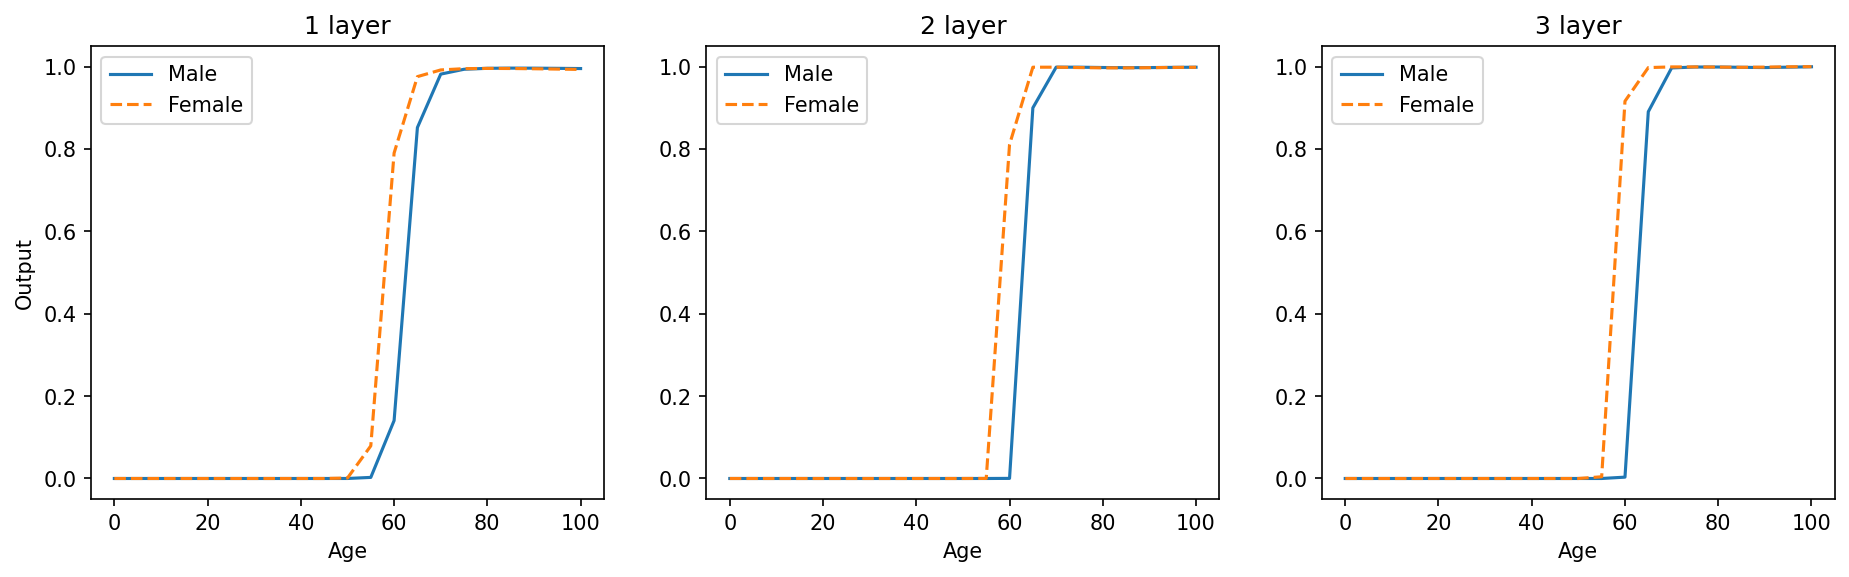

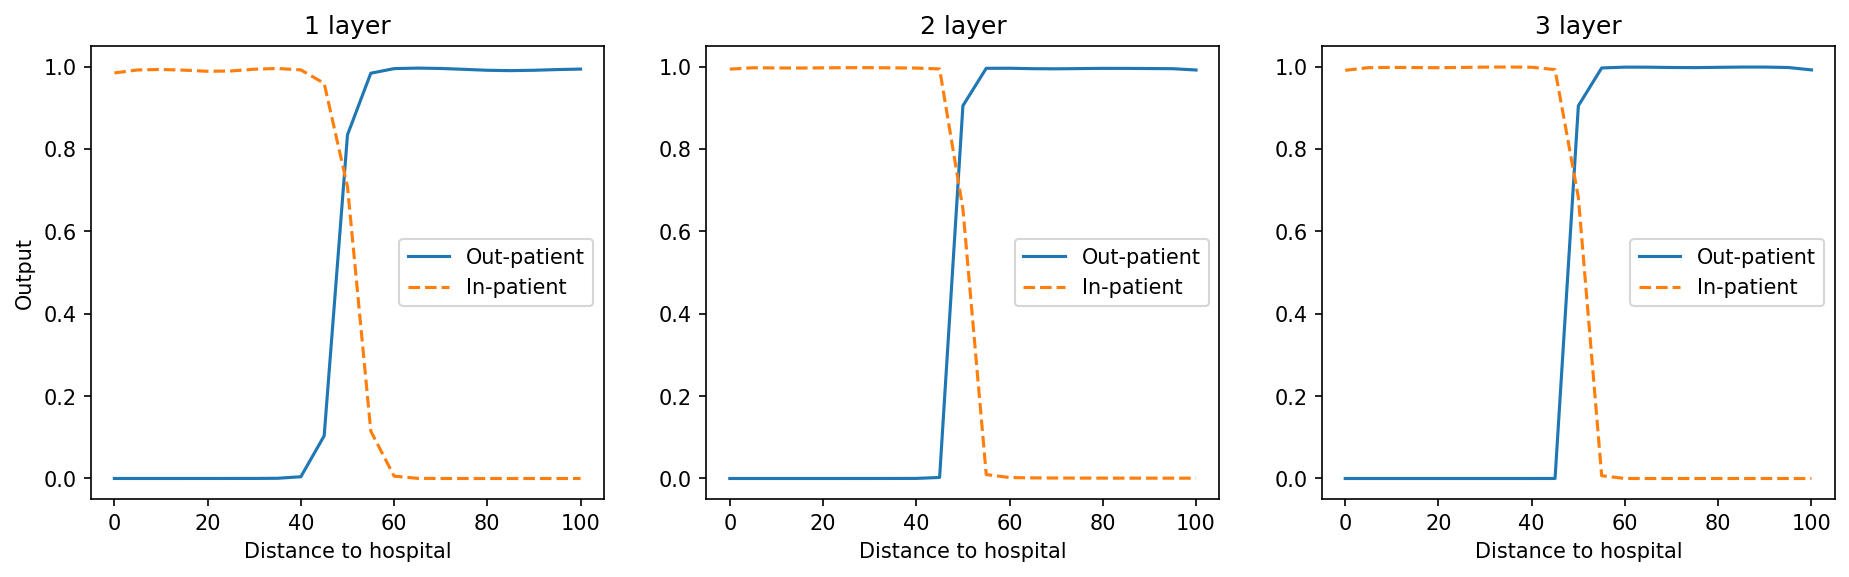

In [67]:
# Plot the age versus the output for each gender and each network
plot_output(ag_df, 'gender', 'age', ['m', 'f'], predict='prediction_A_',
            legend_values=['Male', 'Female'], xlabel='Age', filename='results/plots/simplified_ag_A.png')

# Plot the distance versus the output for each patient type and each network
plot_output(pd_df, 'patient_type', 'distance_to_hospital', ['out', 'in'], predict='prediction_A_',
           legend_values=['Out-patient', 'In-patient'], xlabel='Distance to hospital', filename='results/plots/simplified_pd_A.png')

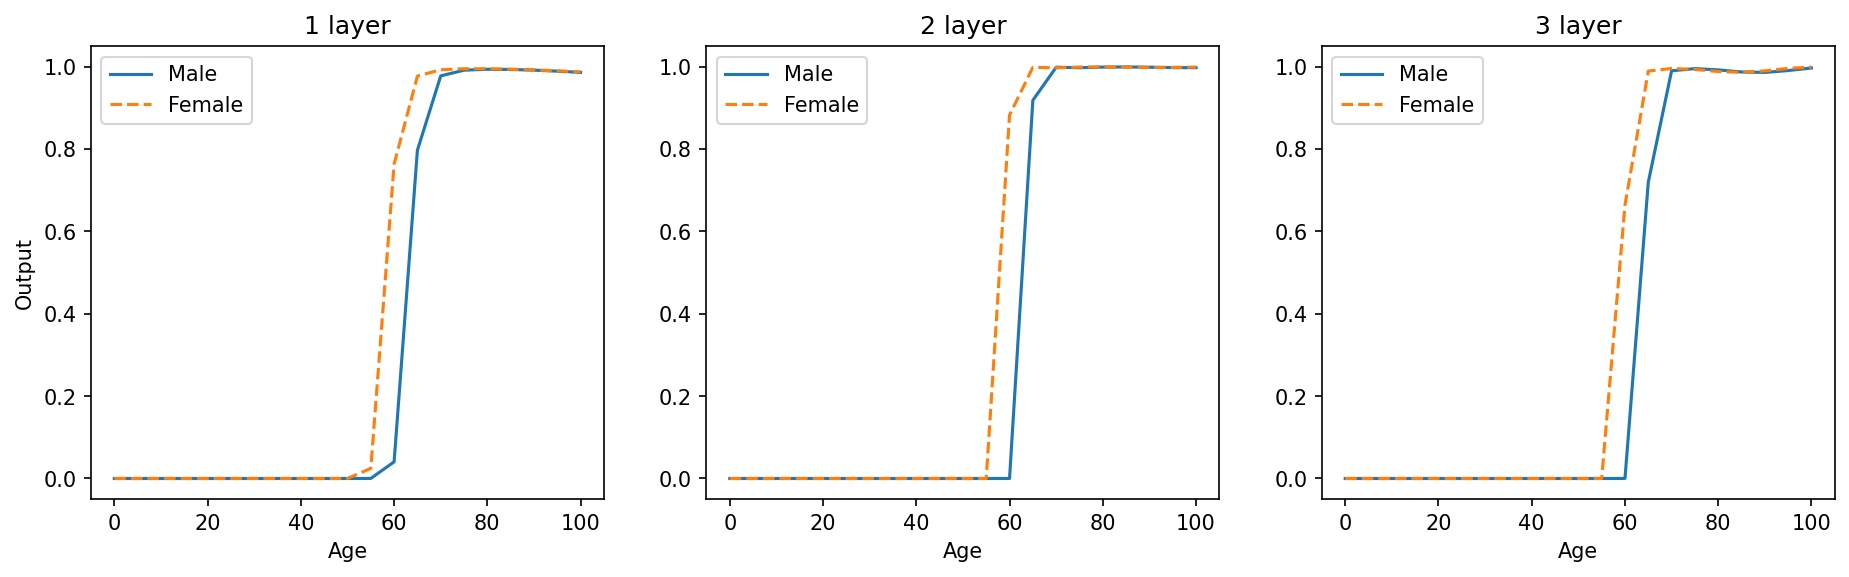

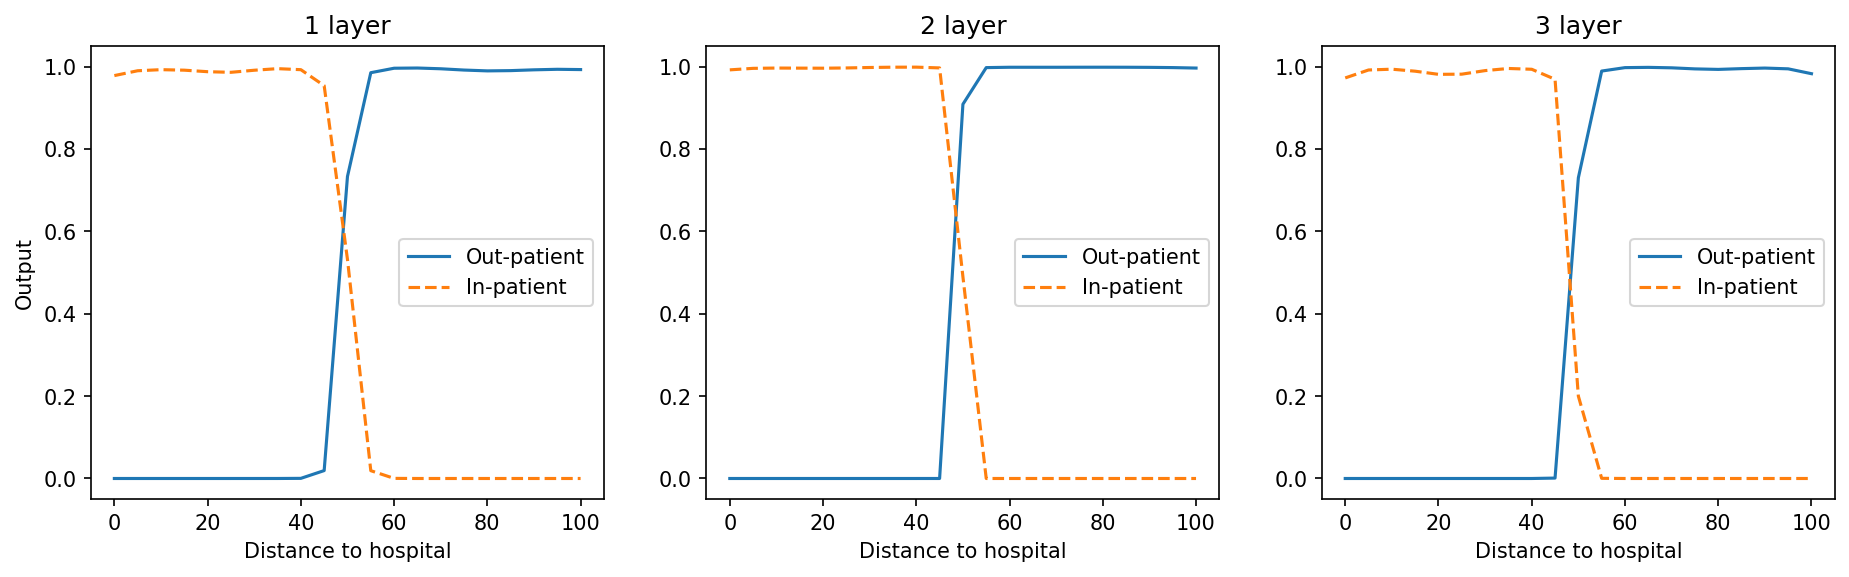

In [68]:
# Plot the age versus the output for each gender and each network
plot_output(ag_df, 'gender', 'age', ['m', 'f'], predict='prediction_B_',
            legend_values=['Male', 'Female'], xlabel='Age', filename='results/plots/simplified_ag_B.png')

# Plot the distance versus the output for each patient type and each network
plot_output(pd_df, 'patient_type', 'distance_to_hospital', ['out', 'in'], predict='prediction_B_',
            legend_values=['Out-patient', 'In-patient'], xlabel='Distance to hospital', filename='results/plots/simplified_pd_B.png')

### Run the experiment multiple times

In [24]:
def convert_accs(accs):
    '''
    Converts list of accuracies to mean and std
    '''
    return str(round(np.mean(accs), 2)) + ' ± ' + str(round(np.std(accs), 2))   

def merge_accuracies(accuracies):
    '''
    Merge the list of accuracies to a pandas dataframe with mean and standard deviations
    '''
    accs = copy.deepcopy(accuracies)
    results = accs[0]
    for idx, x in enumerate(accs):
        if idx == 0: continue
        for train_name, train_data in x.items():
            for test_name, test_data in train_data.items():
                results[train_name][test_name].append(test_data[0])
                if idx == len(accs)-1:
                    results[train_name][test_name] = convert_accs(results[train_name][test_name])
    return pd.DataFrame.from_dict(results).T

def run_experiment(scaler):
    '''
    Train and test neural networks
    '''

    accuracies = {}

    # Training datasets
    datasets_train = {
        'train_A' : create_training_data(db_size=db_size),
        'train_B' : create_training_data_B(db_size=db_size),
    }
    preprocessed_train = {name: preprocess(df, scaler) for name, df in datasets_train.items()}

    # Test datasets
    datasets_test = {
        'test_A' : create_training_data(db_size=db_size),
        'test_B' : create_training_data_B(db_size=db_size),
        'ag' : create_age_gender_dataset(),
        'pd' : create_patient_distance_dataset(),   
    }
    preprocessed_test = {name: preprocess(df, scaler) for name, df in datasets_test.items()}
    
    for train_name, train_data in preprocessed_train.items():       
        # Create and train the neural networks on training set A
        neural_nets = [create_network(hls) for hls in hidden_layers]   
        neural_nets = Parallel(n_jobs=1)(delayed(train_networks)(nn, train_data[0], train_data[1]) 
                                         for nn in neural_nets)
        
        # Initialize accuracies data
        for idx, nn in enumerate(neural_nets):
            accuracies[train_name+'_'+str(idx+1)] = {test_name: [] for test_name in preprocessed_test.keys()}

        # Add accuracies
        for test_name, test_data in preprocessed_test.items():
            for idx, nn in enumerate(neural_nets):
                accuracies[train_name+'_'+str(idx+1)][test_name].append(100*accuracy_score(test_data[1], nn.predict(test_data[0])))

    return accuracies

In [25]:
# Number of runs
num_runs = 50

# Create a scaler to normalize the data
scaler = create_scaler(create_training_data(db_size=db_size))   
accuracies = Parallel(n_jobs=-1)(delayed(run_experiment)(scaler) for run in tqdm(range(0, num_runs)))
results = merge_accuracies(accuracies)
results.to_csv('results/accuracies/50_runs_simplified.csv')
results